In [1]:
pip install git+https://github.com/dbouget/raidionics_seg_lib.git

  Cloning https://github.com/dbouget/raidionics_seg_lib.git to /home/dbouget/.tmp/pip-req-build-rfq2v8g7
  Running command git clone --filter=blob:none --quiet https://github.com/dbouget/raidionics_seg_lib.git /home/dbouget/.tmp/pip-req-build-rfq2v8g7
  Resolved https://github.com/dbouget/raidionics_seg_lib.git to commit f62332d7dfd55e48733c548fcecfbfa2eecf0209
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 10.9 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 14.4 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 704.7 kB/s eta 0:00:001m197.1 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 KB 3.9 MB/s eta 0:00:0031m35.1 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 1.4 MB/s eta 0:00:0031m191.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 KB 3.8 MB/s eta 0:00:00m 

In [4]:
# Download the test data
import os
import requests
import zipfile

test_dir = os.path.join(os.getcwd(), 'unit_tests_results_dir')
os.makedirs(test_dir, exist_ok=True)

test_image_url = 'https://github.com/raidionics/Raidionics-models/releases/download/1.2.0/Samples-RaidionicsSegLib-UnitTest2.zip'
test_model_url = 'https://github.com/dbouget/Raidionics-models/releases/download/1.2.0/Raidionics-MRI_Brain-ONNX-v12.zip'

archive_dl_dest = os.path.join(test_dir, 'inference_volume.zip')
if not os.path.exists(archive_dl_dest):
    headers = {}
    response = requests.get(test_image_url, headers=headers, stream=True)
    response.raise_for_status()
    if response.status_code == requests.codes.ok:
        with open(archive_dl_dest, "wb") as f:
            for chunk in response.iter_content(chunk_size=1048576):
                f.write(chunk)
    with zipfile.ZipFile(archive_dl_dest, 'r') as zip_ref:
        zip_ref.extractall(test_dir)

archive_dl_dest = os.path.join(test_dir, 'brain_model.zip')
if not os.path.exists(archive_dl_dest):
    headers = {}
    response = requests.get(test_model_url, headers=headers, stream=True)
    response.raise_for_status()
    if response.status_code == requests.codes.ok:
        with open(archive_dl_dest, "wb") as f:
            for chunk in response.iter_content(chunk_size=1048576):
                f.write(chunk)
    with zipfile.ZipFile(archive_dl_dest, 'r') as zip_ref:
        zip_ref.extractall(test_dir)

assert(os.path.exists(os.path.join(test_dir, 'MRI_Brain')))
assert(os.path.exists(os.path.join(test_dir, 'inputs')))

In [5]:
# Prepare the configuration file
import configparser
import json
import logging

logging.basicConfig()
logging.getLogger().setLevel(logging.DEBUG)

seg_config = configparser.ConfigParser()
seg_config.add_section('System')
seg_config.set('System', 'gpu_id', "-1")
seg_config.set('System', 'inputs_folder', os.path.join(test_dir, 'inputs'))
seg_config.set('System', 'output_folder', test_dir)
seg_config.set('System', 'model_folder', os.path.join(test_dir, 'MRI_Brain'))
seg_config.add_section('Runtime')
seg_config.set('Runtime', 'reconstruction_method', 'thresholding')
seg_config.set('Runtime', 'reconstruction_order', 'resample_first')
seg_config_filename = os.path.join(test_dir, 'test_seg_config.ini')
with open(seg_config_filename, 'w') as outfile:
    seg_config.write(outfile)

from raidionicsseg.fit import run_model
run_model(seg_config_filename)

INFO:root:Starting inference for folder: inputs, with model: /home/dbouget/Code/Private/raidionics_seg_lib/notebooks/unit_tests_results_dir/MRI_Brain.
INFO:root:LOG: Segmentation - 4 steps.
INFO:root:LOG: Segmentation - Preprocessing - Begin (1/4)
DEBUG:root:Preprocessing - Extracting input data.
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
DEBUG:root:Preprocessing - Resampling.
DEBUG:root:Preprocessing - Background clipping.
DEBUG:root:MRI background cropping with: [14, 11, 45, 195, 217, 230].

DEBUG:root:Preprocessing - Volume resizing.
DEBUG:root:Preprocessing - Intensity normalization.
INFO:root:LOG: Segmentation - Runtime: 5.225970506668091 seconds.
INFO:root:LOG: Segmentation - Preprocessing - End (1/4)
INFO:root:LOG: Segmentation - Inference - Begin (2/4)
DEBUG:root:Loading tensorflow model.
DEBUG:root:Predicting...
DEBUG:root:Starting inference in full volume mode.
INFO:root:L

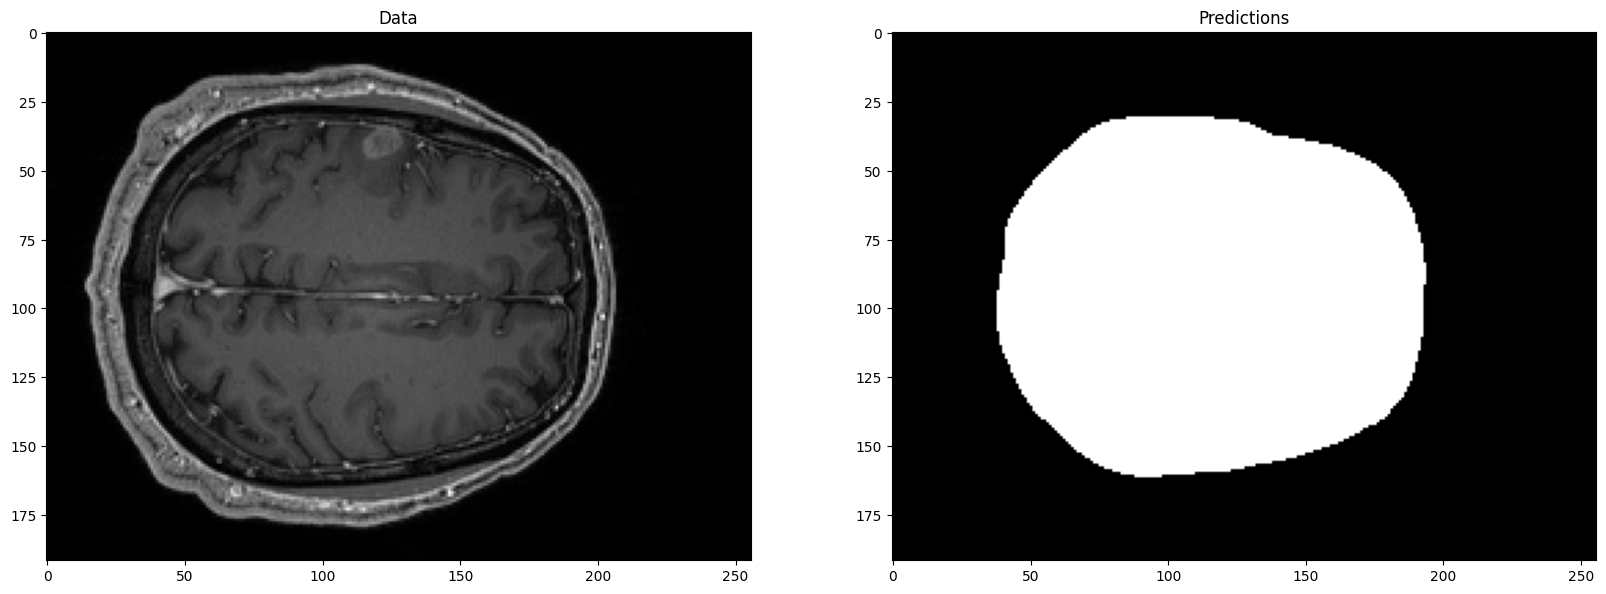

In [10]:
# Inspect the results
!pip install matplotlib
import nibabel as nib
import matplotlib.pyplot as plt

logging.getLogger().setLevel(logging.WARNING)
data_filename = os.path.join(test_dir, 'inputs', 'input0.nii.gz')
predictions_filename = os.path.join(test_dir, 'labels_Brain.nii.gz')

data = nib.load(data_filename).get_fdata()[:]
predictions = nib.load(predictions_filename).get_fdata()[:]

# plot corresponding data and predictions for a single 2D slice
slice_nr = 170
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
ax[0].imshow(data[..., slice_nr], cmap="gray")
ax[1].imshow(predictions[..., slice_nr], cmap="gray")

for i, title in enumerate(["Data", "Predictions"]):
  ax[i].set_title(title)
plt.show()